In [1]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import numpy as np
import sys
import zipfile
import scipy.io as sio
import torch.utils.data as data
import glob

class UCSD(data.Dataset):
    """UCSD pedestrian counting data."""

    def __init__(self, data_dir, annotation_dir, transform=None, in_memory=False):

        self.file_list = []
        self.file_cnts = []
        
        self.in_memory = in_memory
        
        files = glob.glob(
            os.path.join(
                annotation_dir, 
                '*count_roi_mainwalkway.mat'))
        
        for f in files:
            tmp = sio.loadmat(f)
            
            l_count = tmp['count'][0][0].ravel()
            r_count = tmp['count'][0][1].ravel()
            t_count = l_count + r_count
            
            [self.file_cnts.append(c) for c in t_count]
            
            file_parts = os.path.basename(f).split('_')
            seq_id = "_".join(file_parts[0:3])
            
            for i in np.arange(len(t_count)):
                
                img_name = os.path.join(
                        data_dir,
                        seq_id + ".y",
                        "{}_f{:03d}.png".format(seq_id,i+1))
                
                if in_memory:
                    img = Image.open(img_name)
                    img = img.resize((250,250))
                    self.file_list.append(img)
                else:
                    self.file_list.append(img_name)
            
            self.transform = transform

    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        
        if self.in_memory:
            img = self.file_list[idx]
        else:
            img_name = self.file_list[idx]
            img = Image.open(img_name)
            img = img.resize((250,250))

        if self.transform:
            img = self.transform(img)
        return img, self.file_cnts[idx]

In [2]:
import torch
import random

class SubsetSampler(object):

    def __init__(self, subset):
        self.subset = subset

    def __iter__(self):
        return iter(self.subset)

    def __len__(self):
        return len(self.subset)


class RandomSubsetSampler(object):

    def __init__(self, data_source, train_share=0.8):

        # Generate a list of indizes reaching from 0 ... len(data_source)-1
        idxList = list(range(0,len(data_source)))

        # Ensure that list is sorted randomly
        random.shuffle(idxList)

        # Split dataset random shares of train and test data
        numberOfTrainSamples = int(len(data_source) / (1 / train_share))
        
        self.train_samples = idxList[:numberOfTrainSamples]
        self.test_samples = idxList[numberOfTrainSamples:]

    def trainSampler(self):
        return SubsetSampler(self.train_samples)

    def testSampler(self):
        return SubsetSampler(self.test_samples)

In [3]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


class CountingCNN(nn.Module):

    def __init__(self, regression_layer):
        super(CountingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.regression_layer = regression_layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.regression_layer(x)
        return x


In [4]:
def evaluate_cnn_performance(net, max_epoch=100):
    
    learningRate = 0.00001

    performance_statistic = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learningRate)
    
    for epoch in range(max_epoch):

        running_loss = 0.0
        for data in trainloader:

            # get the inputs
            inputs, labels = data
            labels = labels.float()

            inputs = inputs.cuda()
            labels = labels.cuda()

            labels = labels.view(-1,1)

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # Keep track of the loss for reporting purpose
            running_loss += loss.data[0]

        print( str(epoch) + ": " + str(running_loss))

        total_diff = 0.0
        total_squared_diff = 0.0
        total_nr = 0

        for data in testloader:

            inputs, labels = data
            labels = labels.float()

            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(Variable(inputs))
            predicted = outputs.data
            
            # Important: Reduce dimensionality of tensor
            # Otherwise your MAE gets screwed up
            predicted = predicted.view(-1)
            
            # Compute MAE and MSE
            diff = predicted - labels

            squared_diff = diff.pow(2)
            squared_diff = squared_diff.sum()
                
            diff = diff.abs()
            diff = diff.sum()
        
            total_squared_diff += squared_diff
            
            total_diff += diff
            total_nr += labels.size(0)

        mae = total_diff / total_nr
        mse = total_squared_diff / total_nr

        print('Mean Absolute Error: %f' % mae)
        print('Mean Squared Error: %f' % mse)

        # Keep track of the performance to report on performance
        performance_statistic.append((running_loss,mae,mse))
    
    return performance_statistic 

In [5]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets
import torchvision.models as models


transformsData = transforms.Compose([transforms.ToTensor()] )

dataset = UCSD( data_dir='/home/ec2-user/ml_data/uni/dbs/ucsd/ucsdpeds/vidf', 
                annotation_dir='/home/ec2-user/ml_data/uni/dbs/ucsd/vidf-cvpr', 
                transform=transformsData,
                in_memory=True )

sampler = RandomSubsetSampler(dataset)

# Note: Batch Size 10 provides a good trade-off between accuracy and training speed
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=sampler.trainSampler(), num_workers=2 )
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=sampler.testSampler(), num_workers=2)

print("Dataset has been loaded successfully")

Dataset has been loaded successfully


In [ ]:
import pickle

print("###### Train architecture 1 ########")

regression_layer = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_1 = evaluate_cnn_performance(net)

with open('perf_arch_1.pkl', 'wb') as output:
    pickle.dump(performance_statistic_1, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net


In [ ]:
import pickle

print("###### Train architecture 2 ########")

regression_layer = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.Linear(4096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_2 = evaluate_cnn_performance(net)

with open('perf_arch_2.pkl', 'wb') as output:
    pickle.dump(performance_statistic_2, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net

In [7]:
import pickle

print("###### Train architecture 3 ########")

regression_layer = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 2096),
    nn.Linear(2096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_3 = evaluate_cnn_performance(net)

with open('perf_arch_3.pkl', 'wb') as output:
    pickle.dump(performance_statistic_3, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net

###### Train architecture 3 ########
0: 27539.842376708984
Mean Absolute Error: 5.734125
Mean Squared Error: 47.656375
1: 6878.39382648468
Mean Absolute Error: 4.378405
Mean Squared Error: 27.771295
2: 3151.5148684978485
Mean Absolute Error: 2.581845
Mean Squared Error: 11.785557
3: 2111.1080409288406
Mean Absolute Error: 2.285406
Mean Squared Error: 8.254683
4: 1873.3733551502228
Mean Absolute Error: 2.177130
Mean Squared Error: 7.274155
5: 1678.2295999526978
Mean Absolute Error: 2.117448
Mean Squared Error: 6.685745
6: 1452.7968652248383
Mean Absolute Error: 1.969027
Mean Squared Error: 5.857467
7: 1274.9475728273392
Mean Absolute Error: 1.891844
Mean Squared Error: 5.454310
8: 1218.0303937196732
Mean Absolute Error: 1.811992
Mean Squared Error: 5.090656
9: 1072.1324132680893
Mean Absolute Error: 1.723915
Mean Squared Error: 4.725666
10: 941.2823033332825
Mean Absolute Error: 1.826422
Mean Squared Error: 5.365161
11: 876.161116361618
Mean Absolute Error: 1.620532
Mean Squared Error: 

In [8]:
import pickle

print("###### Train architecture 4 ########")

regression_layer = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_4 = evaluate_cnn_performance(net)

with open('perf_arch_4.pkl', 'wb') as output:
    pickle.dump(performance_statistic_4, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net


###### Train architecture 4 ########
0: 28542.69487476349
Mean Absolute Error: 5.853558
Mean Squared Error: 49.167534
1: 7626.134150505066
Mean Absolute Error: 4.859708
Mean Squared Error: 34.728280
2: 4534.4874477386475
Mean Absolute Error: 2.764790
Mean Squared Error: 12.507919
3: 2318.8379443883896
Mean Absolute Error: 2.394201
Mean Squared Error: 9.140443
4: 2013.798778295517
Mean Absolute Error: 2.669436
Mean Squared Error: 10.700998
5: 1674.83123087883
Mean Absolute Error: 2.469677
Mean Squared Error: 9.270656
6: 1524.2127653360367
Mean Absolute Error: 2.159796
Mean Squared Error: 7.133478
7: 1406.4355905056
Mean Absolute Error: 2.007883
Mean Squared Error: 5.965495
8: 1327.765484571457
Mean Absolute Error: 2.033626
Mean Squared Error: 6.107144
9: 1206.1779397130013
Mean Absolute Error: 1.898212
Mean Squared Error: 5.273718
10: 1190.2848978042603
Mean Absolute Error: 1.795303
Mean Squared Error: 4.907148
11: 1097.4346690177917
Mean Absolute Error: 1.772561
Mean Squared Error: 4.7

In [9]:
import pickle

print("###### Train architecture 5 ########")

regression_layer = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.Linear(4096, 4096),
    nn.Dropout(),
    nn.Linear(4096, 2096),
    nn.Linear(2096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_5 = evaluate_cnn_performance(net)

with open('perf_arch_5.pkl', 'wb') as output:
    pickle.dump(performance_statistic_5, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net

###### Train architecture 5 ########
0: 27629.090642929077
Mean Absolute Error: 6.119988
Mean Squared Error: 52.696030
1: 7760.460821151733
Mean Absolute Error: 4.724115
Mean Squared Error: 33.626564
2: 3837.960340976715
Mean Absolute Error: 3.122025
Mean Squared Error: 17.414590
3: 2303.9755647182465
Mean Absolute Error: 2.456555
Mean Squared Error: 9.517425
4: 1792.8000375032425
Mean Absolute Error: 2.109508
Mean Squared Error: 6.748601
5: 1603.5162572860718
Mean Absolute Error: 2.065359
Mean Squared Error: 6.798704
6: 1424.0575284957886
Mean Absolute Error: 2.013127
Mean Squared Error: 6.255416
7: 1338.50961124897
Mean Absolute Error: 1.923734
Mean Squared Error: 5.731168
8: 1280.1202683448792
Mean Absolute Error: 1.735628
Mean Squared Error: 4.601656
9: 1042.1780242919922
Mean Absolute Error: 1.950107
Mean Squared Error: 6.002521
10: 936.0882404446602
Mean Absolute Error: 1.704676
Mean Squared Error: 4.635479
11: 864.4392856359482
Mean Absolute Error: 1.737872
Mean Squared Error: 5

In [6]:
import pickle

print("###### Train architecture 6 ########")

regression_layer = nn.Sequential(
    nn.Linear(256 * 6 * 6, 4096),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 1)
)

# Initialize CNN
net = CountingCNN(regression_layer)
net.cuda()

# Evaluate performance
performance_statistic_1 = evaluate_cnn_performance(net)

with open('perf_arch_6.pkl', 'wb') as output:
    pickle.dump(performance_statistic_1, output, pickle.HIGHEST_PROTOCOL)

# Free memory
del net


###### Train architecture 6 ########
0: 27296.693447113037
Mean Absolute Error: 6.295896
Mean Squared Error: 57.219240
1: 8058.591313362122
Mean Absolute Error: 5.935518
Mean Squared Error: 47.818050
2: 5333.85630273819
Mean Absolute Error: 3.337904
Mean Squared Error: 19.709164
3: 2091.895801782608
Mean Absolute Error: 2.608426
Mean Squared Error: 10.454411
4: 1594.8411885499954
Mean Absolute Error: 2.321202
Mean Squared Error: 8.089786
5: 1360.6177778244019
Mean Absolute Error: 2.184498
Mean Squared Error: 6.934165
6: 1199.3237628936768
Mean Absolute Error: 2.076912
Mean Squared Error: 6.180620
7: 1073.3000597953796
Mean Absolute Error: 1.974555
Mean Squared Error: 5.599336
8: 965.3085769414902
Mean Absolute Error: 1.875765
Mean Squared Error: 5.095324
9: 868.079726934433
Mean Absolute Error: 1.778279
Mean Squared Error: 4.605131
10: 775.5693768262863
Mean Absolute Error: 1.675268
Mean Squared Error: 4.122210
11: 690.1068402528763
Mean Absolute Error: 1.574530
Mean Squared Error: 3.6

Model 1 Performance (based on Min Loss):
	 Min Loss: 92.49734462797642
	 MAE: 0.6252970576286316
	 MSE: 0.6330032005906105

Model 2 Performance (based on Min Loss):
	 Min Loss: 99.80391555279493
	 MAE: 0.7190208721160889
	 MSE: 0.8103772431612015

Model 3 Performance (based on Min Loss):
	 Min Loss: 87.4532272964716
	 MAE: 0.6471014642715454
	 MSE: 0.6685142934322357

Model 4 Performance (based on Min Loss):
	 Min Loss: 138.10282438993454
	 MAE: 0.8791294717788696
	 MSE: 1.2867151856422425

Model 5 Performance (based on Min Loss):
	 Min Loss: 136.4996999502182
	 MAE: 0.8192467403411865
	 MSE: 1.1393485468626023



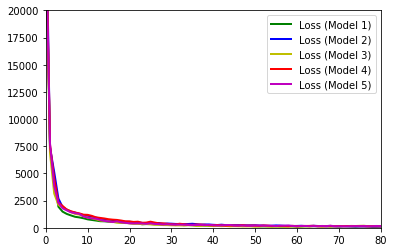

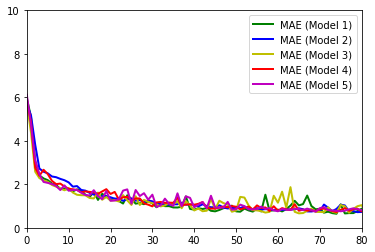

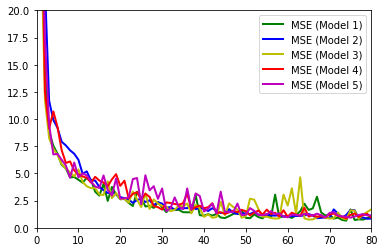

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle

def plot(plt, values, line_spec='g', label=None):
    
    y_values = values
    x_values = list(range(len(values)))
    
    if label is None:
        plt.plot(x_values, y_values, line_spec, linewidth=2.0)
    else:
        plt.plot(x_values, y_values, line_spec, label=label, linewidth=2.0)
        plt.legend()
        
        
with open('perf_arch_1.pkl', 'rb') as input:
    performance_statistic_1 = pickle.load(input)
with open('perf_arch_2.pkl', 'rb') as input:
    performance_statistic_2 = pickle.load(input)
with open('perf_arch_3.pkl', 'rb') as input:
    performance_statistic_3 = pickle.load(input)
with open('perf_arch_4.pkl', 'rb') as input:
    performance_statistic_4 = pickle.load(input)
with open('perf_arch_5.pkl', 'rb') as input:
    performance_statistic_5 = pickle.load(input)
with open('perf_arch_6.pkl', 'rb') as input:
    performance_statistic_5 = pickle.load(input)
  
loss_lst_1, mae_lst_1, mse_lst_1 = zip(*performance_statistic_1)
loss_lst_2, mae_lst_2, mse_lst_2 = zip(*performance_statistic_2)
loss_lst_3, mae_lst_3, mse_lst_3 = zip(*performance_statistic_3)
loss_lst_4, mae_lst_4, mse_lst_4 = zip(*performance_statistic_4)
loss_lst_5, mae_lst_5, mse_lst_5 = zip(*performance_statistic_5)
loss_lst_6, mae_lst_6, mse_lst_6 = zip(*performance_statistic_6)

# Converts the tuples into a list
loss_lst_1 = list(loss_lst_1)
loss_lst_2 = list(loss_lst_2)
loss_lst_3 = list(loss_lst_3)
loss_lst_4 = list(loss_lst_4)
loss_lst_5 = list(loss_lst_5)
loss_lst_6 = list(loss_lst_6)

mae_lst_1 = list(mae_lst_1)
mae_lst_2 = list(mae_lst_2)
mae_lst_3 = list(mae_lst_3)
mae_lst_4 = list(mae_lst_4)
mae_lst_5 = list(mae_lst_5)
mae_lst_6 = list(mae_lst_6)

mse_lst_1 = list(mse_lst_1)
mse_lst_2 = list(mse_lst_2)
mse_lst_3 = list(mse_lst_3)
mse_lst_4 = list(mse_lst_4)
mse_lst_5 = list(mse_lst_5)
mse_lst_ = list(mse_lst_5)


max_epoch = 80
max_loss = 20000
max_mae = 10
max_mse = 20

# Plot the loss of every network
plt.figure()
plt.axis([0,max_epoch,0,max_loss])

plot(plt,loss_lst_1, 'g', 'Loss (Model 1)')
plot(plt,loss_lst_2, 'b', 'Loss (Model 2)')
plot(plt,loss_lst_3, 'y', 'Loss (Model 3)')
plot(plt,loss_lst_4, 'r', 'Loss (Model 4)')
plot(plt,loss_lst_5, 'm', 'Loss (Model 5)')

# Plot the MAE of every network
plt.figure()
plt.axis([0,max_epoch,0,max_mae])

plot(plt,mae_lst_1, 'g', 'MAE (Model 1)')
plot(plt,mae_lst_2, 'b', 'MAE (Model 2)')
plot(plt,mae_lst_3, 'y', 'MAE (Model 3)')
plot(plt,mae_lst_4, 'r', 'MAE (Model 4)')
plot(plt,mae_lst_5, 'm', 'MAE (Model 5)')

# Plot the MSE of every network
plt.figure()
plt.axis([0,max_epoch,0,max_mse])

plot(plt,mse_lst_1, 'g', 'MSE (Model 1)')
plot(plt,mse_lst_2, 'b', 'MSE (Model 2)')
plot(plt,mse_lst_3, 'y', 'MSE (Model 3)')
plot(plt,mse_lst_4, 'r', 'MSE (Model 4)')
plot(plt,mse_lst_5, 'm', 'MSE (Model 5)')

min_loss_1 = min(loss_lst_1)
min_loss_idx_1 = loss_lst_1.index(min_loss_1)

print("Model 1 Performance (based on Min Loss):")
print("\t Min Loss: " + str(min_loss_1))
print("\t MAE: " + str(mae_lst_1[min_loss_idx_1]))
print("\t MSE: " + str(mse_lst_1[min_loss_idx_1]))
print()

min_loss_2 = min(loss_lst_2)
min_loss_idx_2 = loss_lst_2.index(min_loss_2)

print("Model 2 Performance (based on Min Loss):")
print("\t Min Loss: " + str(min_loss_2))
print("\t MAE: " + str(mae_lst_2[min_loss_idx_2]))
print("\t MSE: " + str(mse_lst_2[min_loss_idx_2]))
print()

min_loss_3 = min(loss_lst_3)
min_loss_idx_3 = loss_lst_3.index(min_loss_3)

print("Model 3 Performance (based on Min Loss):")
print("\t Min Loss: " + str(min_loss_3))
print("\t MAE: " + str(mae_lst_3[min_loss_idx_3]))
print("\t MSE: " + str(mse_lst_3[min_loss_idx_3]))
print()

min_loss_4 = min(loss_lst_4)
min_loss_idx_4 = loss_lst_4.index(min_loss_4)

print("Model 4 Performance (based on Min Loss):")
print("\t Min Loss: " + str(min_loss_4))
print("\t MAE: " + str(mae_lst_4[min_loss_idx_4]))
print("\t MSE: " + str(mse_lst_4[min_loss_idx_4]))
print()

min_loss_5 = min(loss_lst_5)
min_loss_idx_5 = loss_lst_5.index(min_loss_5)

print("Model 5 Performance (based on Min Loss):")
print("\t Min Loss: " + str(min_loss_5))
print("\t MAE: " + str(mae_lst_5[min_loss_idx_5]))
print("\t MSE: " + str(mse_lst_5[min_loss_idx_5]))
print()
